# Imports

In [19]:
import pandas as pd
import numpy as np 

from pyhhmm.gaussian import GaussianHMM

import yfinance as yf

import matplotlib.pyplot as plt

# Fetch Data

In [20]:
# Data Extraction
start_date = "2020-01-01"
end_date = "2023-06-01"
symbol = "SPY"

# USE YAHOO FINANCE 
data = yf.download(symbol ,  start_date , end_date )
data = data[["Open" , "High" , "Low" , "Close" ]]

[*********************100%***********************]  1 of 1 completed


In [21]:
# Add Returns and Range    
# Returns = (todays price divided by yesterdays)     # ROI since Yesterday
# Range   = (todays high price divided todays low)   # volitility from highest point to lowest within day

df = data.copy()
df["Returns"] = (df["Close"] / df["Close"].shift(1)) - 1
df["Range"]   = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)

print("Length: ", len(df))

Length:  858


# Add Moving Average

In [22]:
df["12_MA"] = df["Close"].rolling(window=12).mean()
df["21_MA"] = df["Close"].rolling(window=21).mean()

# Train/Test Split Data

In [23]:
x_train = df[["Returns" , "Range"]].iloc[:500]
x_test = df[["Returns" , "Range"]].iloc[500:]
save_df = df.iloc[500:]



print(f"Train Data Length: {len(x_train)}")
print(f"Test Data Length: {len(x_test)}")

Train Data Length: 500
Test Data Length: 358


# Train HMM

In [24]:
# Train Hidden Markov Model
model = GaussianHMM(n_states=4, covariance_type="full" , n_emissions=2)
train = model.train([np.array(x_train.values)])

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Test HMM

In [25]:
# Test Hidden Markov Model
test = model.predict([x_train.values])[0]

# Test Predictions

In [26]:
df_main = save_df.copy()
df_main.drop(columns = ["High" , "Low"], inplace = True)

hmm_results = model.predict([x_test.values])[0]
df_main["HMM"] = hmm_results

# Run BackTest
- if the 12 day moving average is greater than the 21 day moving average, place signal
    -  1 : go long
    -  0 : do nothing
    - -1 : go short

In [27]:
# Signals
df_main.loc[df_main["12_MA"] > df_main["21_MA"] , "MA_Signal" ] = int(1)
df_main.loc[df_main["12_MA"] <= df_main["21_MA"] , "MA_Signal" ] = 0

In [28]:
# Check Each row to see if within positive signals from HMM    
favorable_states = [0 , 1 , 2 , 3]
hmm_values = df_main["HMM"].values

# 0 if no   ||   1 if yes
hmm_values = [1 if x in favorable_states else 0 for x in hmm_values]


df_main["HMM_Signal"] = hmm_values

In [29]:
# Add Combined "Main" Signal   (if moving average and HMM signals are green)
df_main["Main_Signal"] = 0
df_main.loc[   (df_main["MA_Signal"] == 1) &  (df_main["HMM_Signal"] == 1 ), "Main_Signal" ] = int(1)


df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [30]:
# Benchmmark Returns
df_main["lrets_bench"] = np.log(df_main["Close"] / df_main["Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exponent"] = np.exp(df_main["bench_prod"]) - 1

In [31]:
# Strategy Returns
df_main["lrets_strat"] = np.log(df_main["Open"].shift(1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exponent"] = np.exp(df_main["lrets_prod"]) - 1

# Review Results


In [32]:
df_main.dropna(inplace=True)


df_main.tail(5)

,Open,Close,Returns,Range,12_MA,21_MA,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exponent,lrets_strat,lrets_prod,strat_prod_exponent
Date,,,,,,,,,,,,,,,,
2023-05-24,412.420013,411.089996,-0.007245,0.007173,413.984169,412.637143,1,1.0,1,1.0,-0.007271,-0.148432,-0.137941,0.011236,0.147764,0.159239
2023-05-25,414.739990,414.649994,0.008660,0.009093,414.294169,413.127143,1,1.0,1,1.0,0.008623,-0.139809,-0.130476,-0.005610,0.142155,0.152755
2023-05-26,415.329987,420.019989,0.012951,0.013293,414.891668,413.489524,1,1.0,1,1.0,0.012868,-0.126942,-0.119215,-0.001422,0.140733,0.151117
2023-05-30,422.029999,420.179993,0.000381,0.009170,415.562500,413.691905,1,1.0,1,1.0,0.000381,-0.126561,-0.118879,-0.016003,0.124730,0.132842
2023-05-31,418.279999,417.850006,-0.005545,0.007208,416.084167,413.803333,1,1.0,1,1.0,-0.005561,-0.132121,-0.123765,0.008925,0.133655,0.142999


# Calculate Metrics

In [39]:
# Sharpe Ratio Function
def sharpe_ratio_calc(returns_series):
    TradingDays = 255
    TradingDays_SQRT = np.sqrt(TradingDays)
    risk_free_rate = 0.01
    mean = returns_series.mean() * TradingDays
    sigma = returns_series.std() * TradingDays_SQRT
    sharpe_ratio = round((mean - risk_free_rate) / sigma , 2 )
    return sharpe_ratio

In [40]:
# Metrics
bench_returns = round(df_main["bench_prod_exponent"].values[-1] * 100 , 1)
strategy_returns = round(df_main["strat_prod_exponent"].values[-1] * 100 , 1)


bench_sharpe = sharpe_ratio_calc(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio_calc(df_main["lrets_strat"].values)

In [43]:
# Print metrics
print(f"Returns Benchmark: {bench_returns}%")
print(f"Returns Strategy: {strategy_returns}%")

print("-------------------")

print(f"Sharpe Benchmark: {bench_sharpe}%")
print(f"Sharpe Strategy: {strat_sharpe}%")



print("\n\n Sharpe ratio is saying 'for every dollar of reward, how mmuch risk am i taking?'")

Returns Benchmark: -12.4%
Returns Strategy: 14.3%
-------------------
Sharpe Benchmark: -0.47%
Sharpe Strategy: 0.61%


 Sharpe ratio is saying 'for every dollar of reward, how mmuch risk am i taking?'


# Plot Results

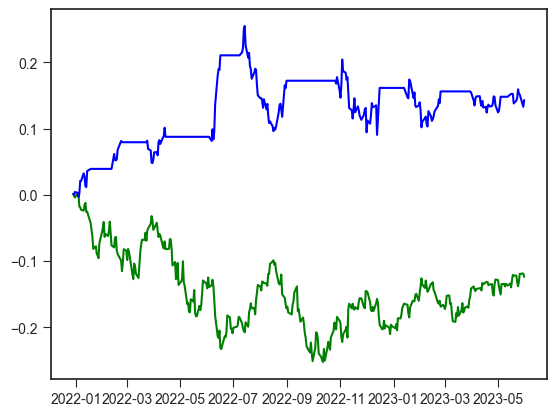

In [47]:
# Plot Equity Curves
fig = plt.Figure(figsize=(18,10))
plt.plot(df_main["bench_prod_exponent"], color="green" )
plt.plot(df_main["strat_prod_exponent"] , color="blue")

plt.show()